GitHub: https://github.com/naimahassen/SIT799/blob/master/6.1HD%20-%20Explainable%20AI/6.1HD%20-%20Explainable%20AI.ipynb

Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [1]:
!pip install numpy
!pip install matplotlib
!pip install lime
!pip install shap
!pip install sklearn
!pip install xgboost
!pip install graphviz
!pip install pydot
!pip install pydotplus
!pip install seaborn


^C
Traceback (most recent call last):
  File "/Users/naimahassen/opt/anaconda3/bin/pip", line 7, in <module>
    from pip._internal.cli.main import main
  File "/Users/naimahassen/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/naimahassen/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/Users/naimahassen/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/Users/naimahassen/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/cmdoptions.py", line 28, in <module>
    from pip._internal.models.target_python import TargetPython
  File "/Users/naimahassen/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/models/target_python.py", line 4, i

Run the following cell to load the packages you will need.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [4]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [5]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

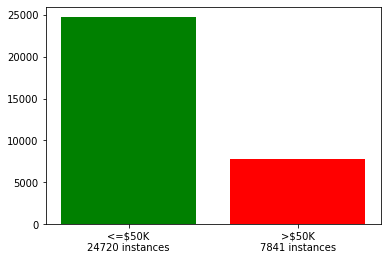

In [6]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [8]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [9]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [10]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

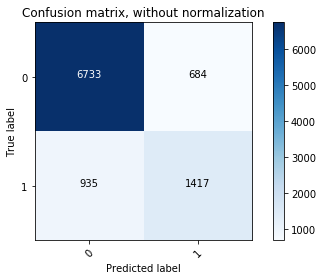

In [11]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***

**Task 1**: Please provide comments on the performance of the classifier.

***

The classifer that has been depecited has a relatively high accuracy (~84%). In addition to this, the classifier has a high recall and precision score for label 0 in comparsion to the low accuracy, recall and precision of label 1. It can be seen that the classifier is able to out perfrom in lable 0 compared to label 1 

# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

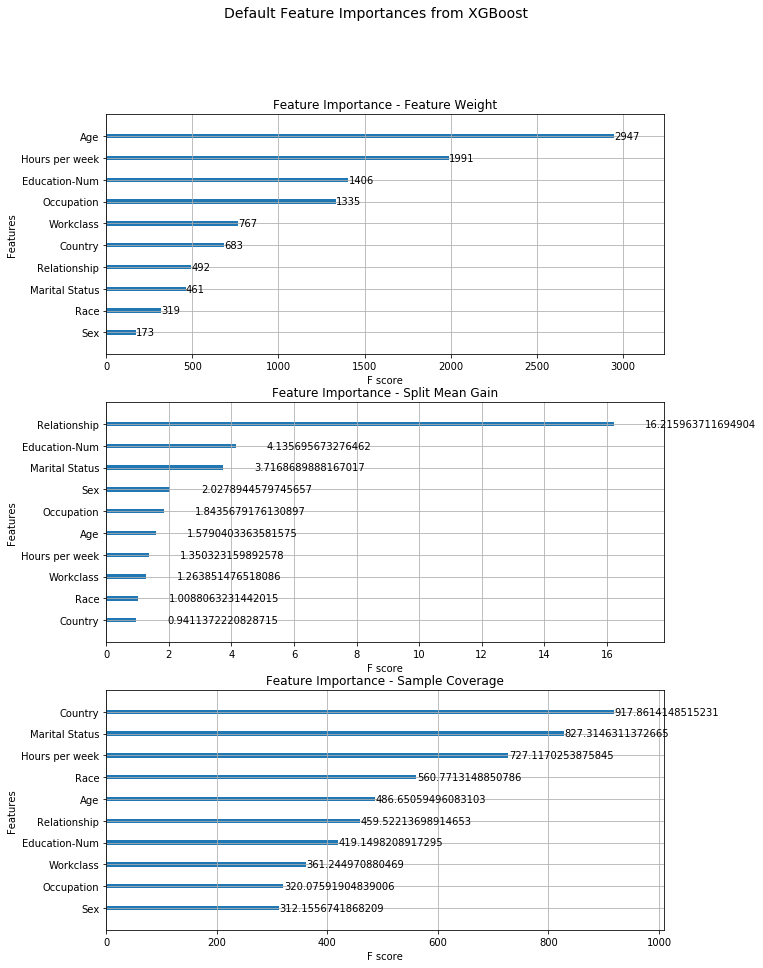

In [12]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

***

The feature weight presented in the graphs above refers to the number of times a feature is present in a tree accorss an ensamble of trees. In the graph above we can see that the element age  has the highest appearance and percentage weight compared to all the other feautres present. The second feautre present in the graphs is the gain which is based on the average gain of split.  Essentially this means that the split gain is the relative contribution for the correspoinding feature of the model that being calculated. The feature that has the highest split mean gain when it is compared to other feature feature suggests that it has a higher significance when generating a predcition. The coverage is essentially based on the avaerage coverage of split which use the feature, which is the number of samples that have been affected. It is predicited in the graph that country is the feature that has the highest observation with respect to the other trees present.




# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [13]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [14]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [15]:
# Change only the value of to select that person:
i = 16
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.0834875645903452
Prediction_local [0.37143706]
Right: 0.8874259
********************
Test id:  16
Probability( <= $50K ) = 0.1125741
Probability( > $50K ) = 0.8874259
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


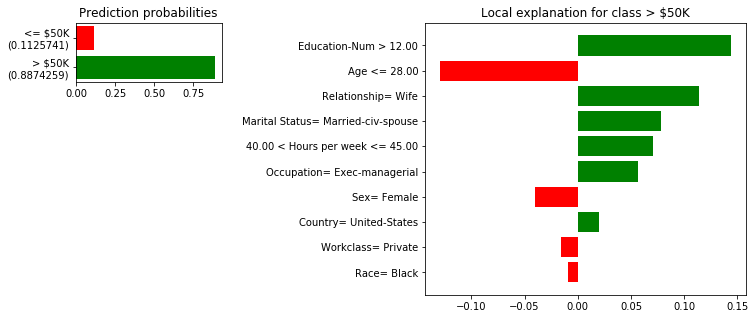

<Figure size 432x288 with 0 Axes>

In [16]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

***

Built on the different parameters mentioned in the above graph; such as sex, occupation, age, race and hours per weel, lime incorparetes these featuers in order to effectively explain the prediction of the instance where class label 0 would be <= $50K. It is through the incorporation of these different parameters that the probabiblity that has predicited is ~99%.  The parameters are categorised in decending order where the inital parameter (age) can be seen to be the most contributing factor. LIME uses this to show that these parameter have a significant role in pacing the instance in the predicted class. 

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [22]:
instanceModified1 = X_test.iloc[2]
instanceModified1['Age'] = 70
instanceModified1['Hours per week'] = 50
print(instanceModified1)

Age               70.0
Workclass          2.0
Education-Num     13.0
Marital Status     0.0
Occupation        10.0
Relationship       4.0
Race               4.0
Sex                0.0
Hours per week    50.0
Country           39.0
Name: 3474, dtype: float32


Intercept 0.06154021131478264
Prediction_local [0.3352196]
Right: 0.65744567


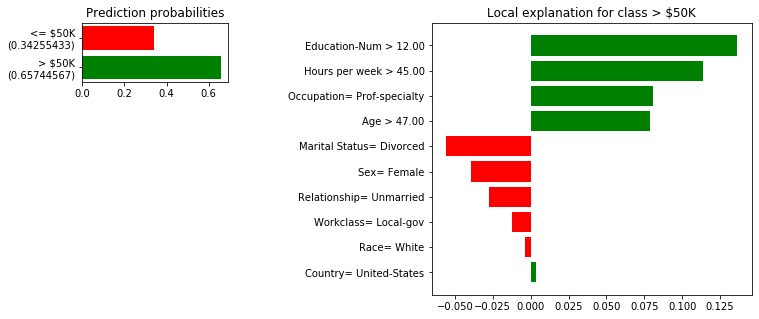

<Figure size 432x288 with 0 Axes>

In [26]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?


For this task I had changed the features age and hours per week. In the graphs depcited we can see that these two specific parameters have the most contribution to the output classifier. Consequently by changing these two features we can see a signifacnt change in the new figure ^^



## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [27]:
# Change only the value of to select that person:
j = 60


###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept -0.060798291472037885
Prediction_local [0.54504177]
Right: 0.78172773
********************
Test id:  60
Probability( <= $50K ) = 0.21827227
Probability( > $50K ) = 0.78172773
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


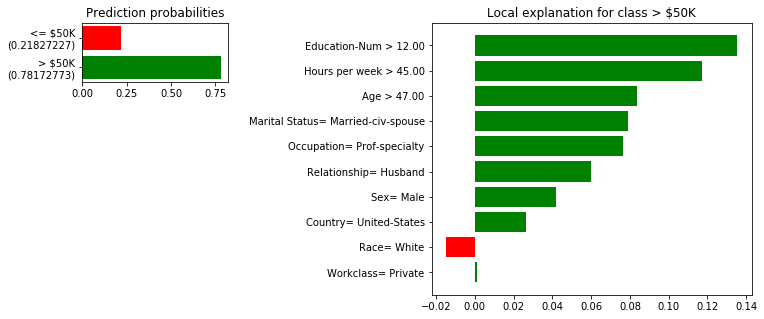

<Figure size 432x288 with 0 Axes>

In [28]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

***

LIME uses the parameters mentioned in the above figure to depct the prediction of the instance in the class label which >50K. Based on the parameters shown above, the probability of the prediction is approximately 50%. Similar to the figure above, this graph is also in decending order of parameter with the highest prediction.
LIME uses all these parameters to to show the importance of certain features as seen above. In the digrams above we can see that

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [29]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Sex'] = 1.0
instanceModified2['Hours per week'] = 20
print(instanceModified2)

Age               57.0
Workclass          4.0
Education-Num     14.0
Marital Status     2.0
Occupation        10.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    20.0
Country           39.0
Name: 24738, dtype: float32


Intercept 0.05475900289385499
Prediction_local [0.42353192]
Right: 0.72110605


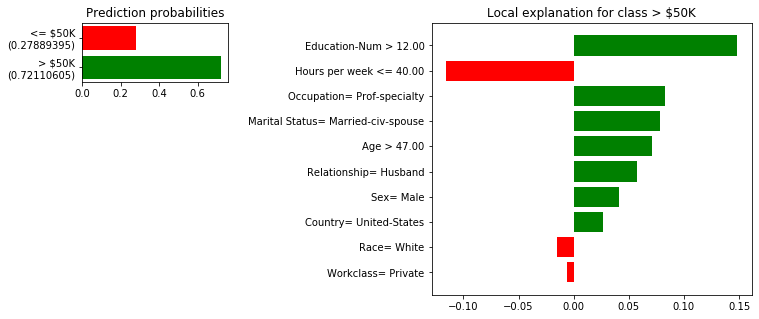

<Figure size 432x288 with 0 Axes>

In [30]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?

For this task I chose to change "sex" and "hours per week" based on the prediction probablity to be >50K. As gender and hours per week have major impact on the income that is recieved, these two feature have contribution to the cliassifier. Therefore, this results in the change prediction of the clasifier and classifying the the instance in the class label 1 instad of the class labe 0




# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [31]:
# Change only the value of to select that person:
k = 4
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept -0.05610512747185312
Prediction_local [0.521458]
Right: 0.72800654
********************
Test id:  4
Probability( <= $50K ) = 0.27199346
Probability( > $50K ) = 0.72800654
Predicted Label: 1
True class:  0
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


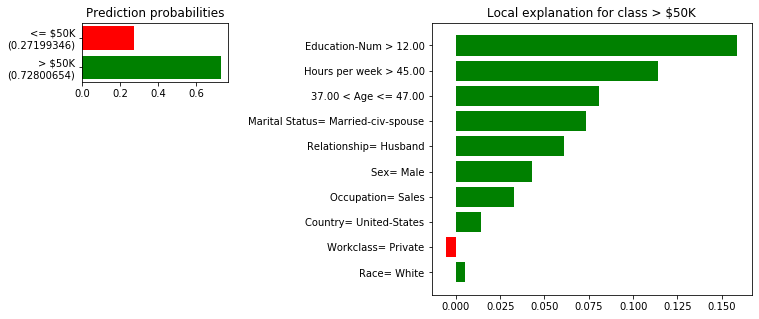

<Figure size 432x288 with 0 Axes>

In [32]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.

***

Based on the following parameters; hours per week, education-num, age, marital status, sex, relation, country and occupation- LIME uses all these parameters to depict why the prediction of the instance is in the class >50K, however the actual class label should be <50K. The changing of these value changes the models prediction. When linking these different parameters to real world examples such as older workers getting paid more based on experince and being hired based on race- the changing of these features reflect real world scenarios. As shown in the graph above, we can see that the appearance of these parameters are showing in decending order of importance. 

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [38]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Age'] = 43
instanceModified3['Marital Status'] = 1
print(instanceModified3)

Age               43.0
Workclass          4.0
Education-Num     13.0
Marital Status     1.0
Occupation        12.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    60.0
Country           39.0
Name: 26674, dtype: float32


Intercept -0.027104365819066556
Prediction_local [0.55724173]
Right: 0.786278


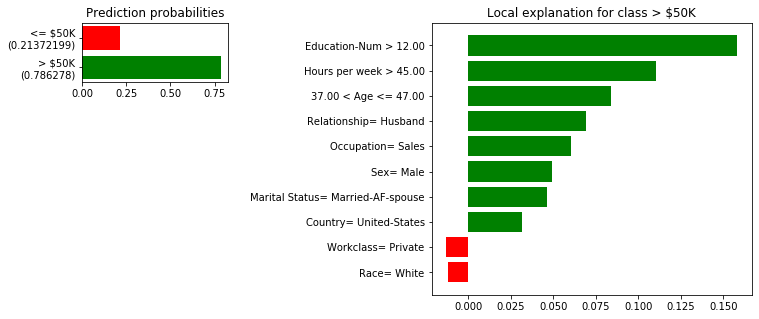

<Figure size 432x288 with 0 Axes>

In [39]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?

For this task, I have chosen the age and martial status as the parameters. As seen in the graph, these two have the largest influence towards the classfier. 





# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [40]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [41]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [42]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



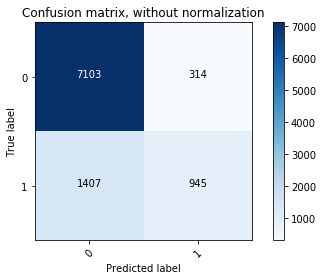

In [43]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***
**Task 15**:  Please provide comments on the performance of the decision Tree.


# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [44]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])


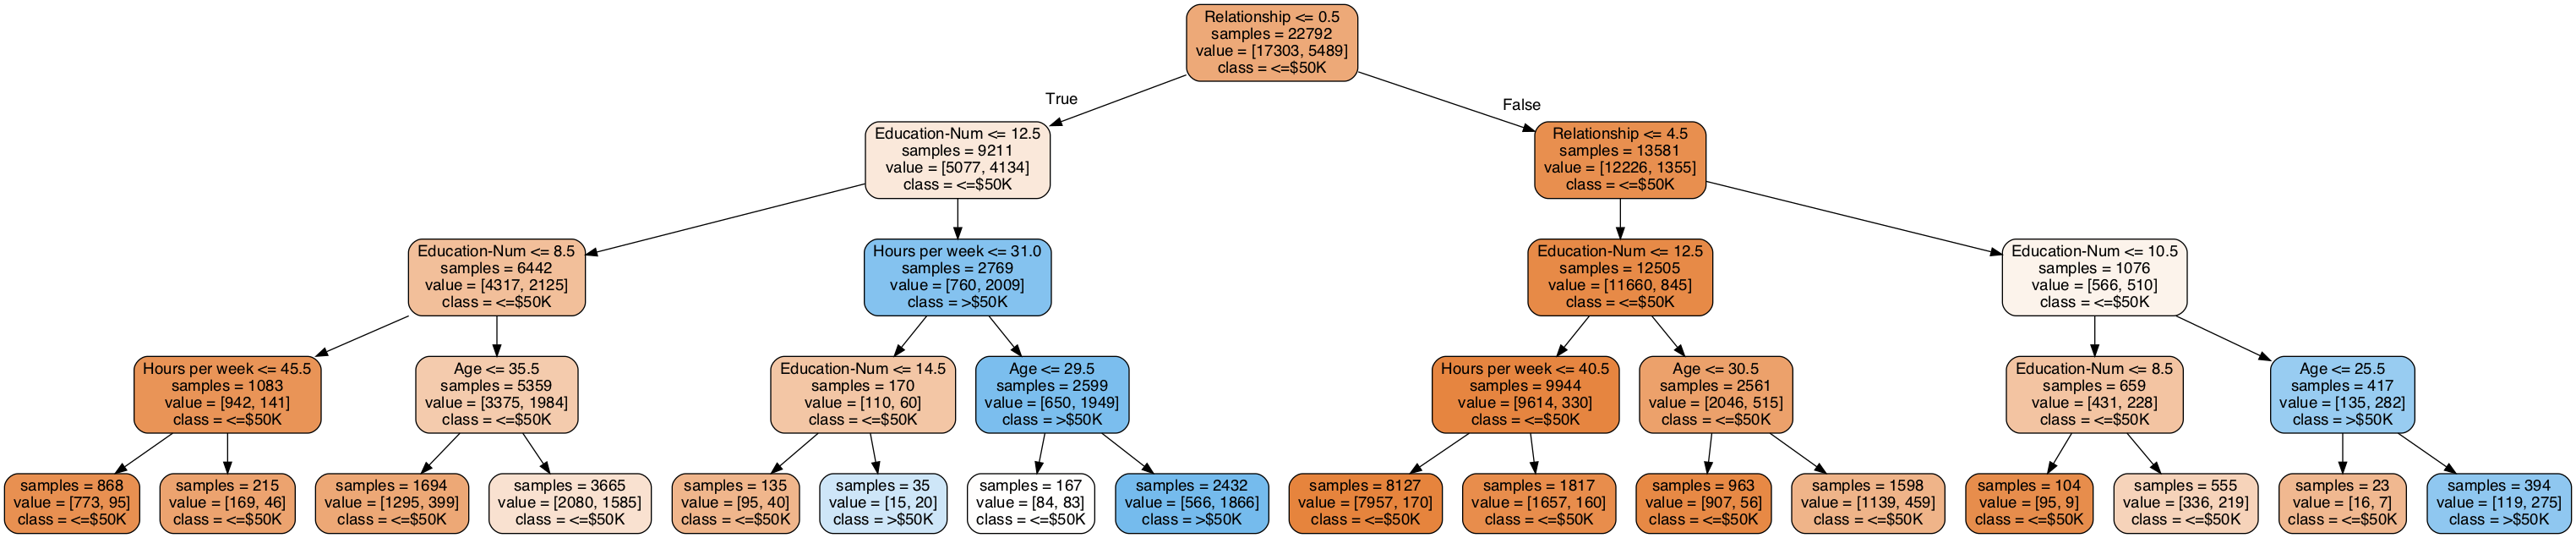

In [45]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 


While looking over the tree structure, it is difficult to determine what teh different shades and colors implies. However, through futher analysis we are able to determine the darker shades are incations of a higher predicted target values. For example, from the diagram presented above, depicts that there are two classes- one being <= 50k and the other => 50K. As it is already known that that the a large portion of the sample lies with in the class <=50K

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [46]:
# Change only the value of to select that person:
h = 2
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.13725705070697167
Prediction_local [0.34887898]
Right: 0.2872340425531915
********************
Test id:  2
Probability( <= $50K ) = 0.7127659574468085
Probability( > $50K ) = 0.2872340425531915
Predicted Label: 0
True class:  0
********************


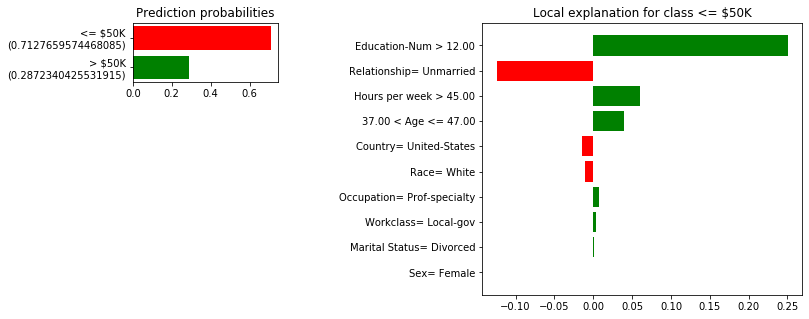

<Figure size 432x288 with 0 Axes>

In [47]:
plot_explanation(exp4, mapping)


***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.


Based on the parameters used in the graphs above, LIME uses these to portray the prediciton of the instance <=50K. We can see that this give a probability of the prediciton of class that is 0.979 in this situation. The parameters are mentioned in decending order where the initial pararmeter is the most predicited. LIME shows that these parameters play a role in placing instance in precited class 0


# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

Intercept 0.034323441256232476
Prediction_local [0.40076523]
Right: 0.5636226
********************
Test id:  4
Probability( <= $50K ) = 0.27199346
Probability( > $50K ) = 0.72800654
Predicted Label: 1
********************




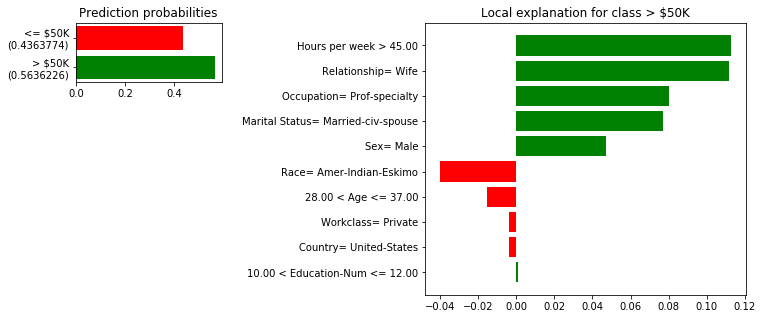

<Figure size 432x288 with 0 Axes>

In [58]:
# Copied from above ^^
#k = 4

sample_sample = np.array ([29, 4, 12, 2, 10, 5, 0 , 1 ,46 ,39])

#exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  #distance_metric='euclidean', 
                                  #num_features=len(X_test.iloc[h].values)

exp4 = explainer.explain_instance(sample_sample, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(sample_sample))
proba3 = tree.predict_proba([sample_sample])

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
#print('True class: ' , y_test[k])
print("********************\n\n")

plot_explanation(exp4, mapping)


Looking at the tree diagram above, we are told to create a diagram
where the individual is supposed to be classified as >50K. The following parameters were set as according to 
achieve the diagram above ^^. 
education-num: 10.5 was false so the encoded label was 12
age: the decision tree at the node predicted the class to be greater that 50K the value selected was 29
relationship: as depicted in the tree diagram, <=0.5 is considered to be false. Relationship encoded label =5
other values mentioned in the diagram were predicted using the XGBoost
The parameteres listed above will be classfieid a having an income of greate than 50K. And as depicted by LIME, 
the parameters that have the most emphasis are listed in decending order





# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

